# Gated Reccurent United

In this jupyter notebook you will find the implementation of the gated reccurent united algorithm using the sklearn library. It will help to test this algorithm and to complete [forecasting.md](https://github.com/Hurence/historian/blob/forecasting/docs/forecasting.md) document.

First we need to import all the different libraries that we will use and we make the 'create_dataset' function, it will be used later. 

In [1]:
import time
import math
import numpy as np
import sklearn.linear_model as sk
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# GRU
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)

#### 1) Dataset

We prepare the dataset for the next step.

In [3]:
# Load the dataset
# ts_data = pd.read_csv('../data/dataHistorian.csv', sep=';', encoding='cp1252')
ts_data = pd.read_csv('../data/it-data-4metrics.csv', sep=',')
gru_data = pd.read_csv('GRU_id2.csv')

# Delete the useless columns
ts_data = ts_data.iloc[:,0:4]
ts_data.head()

,metric_id,timestamp,value,metric_name
0,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157723,13.375,cpu_prct_used
1,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157423,13.500,cpu_prct_used
2,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157123,13.375,cpu_prct_used
3,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156823,13.500,cpu_prct_used
4,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156523,13.750,cpu_prct_used


We create to dictionnary to class all the time series according to their metric_name and their metric_id.

In [4]:
# Creation of the dictionnary of all the metric_name in association with their metric_id
dic_name = {}
dic_id = {}
for indx in gru_data.index:
    if gru_data['metric_name'][indx] not in dic_name.keys():
        dic_name[gru_data['metric_name'][indx]] = []
    if gru_data['metric_id'][indx] not in dic_name[gru_data['metric_name'][indx]]:
        dic_name[gru_data['metric_name'][indx]].append(gru_data['metric_id'][indx])
        dic_id[gru_data['metric_id'][indx]] = [gru_data['metric_name'][indx]]
keys_name = list(dic_name.keys())
keys_id = list(dic_id.keys())

#### 2) Training the neural network

We are going to separate the series into a training and a testing serie (for each metric_id). Then this series are going to fit the neural network and to test it. We will store the results in dic_id for keep them and reuse them later.

In [5]:
dicOpt = {}
for indx_name in keys_name:
    tmp = float('inf')
    indexOpt = 0
    for indx in dic_name[indx_name]:
        indexNames = gru_data[ gru_data['metric_id'] == indx ].index
        valeur = gru_data.loc[indexNames, 'mean_squared_error'].values
        if 1 < valeur[0] < tmp:
            tmp, indexOpt = valeur[0], indexNames
    if indexOpt == 0:
        tmp = float('inf')
        indexOpt = 0
        for indx in dic_name[indx_name]:
            indexNames = gru_data[ gru_data['metric_id'] == indx ].index
            valeur = gru_data.loc[indexNames, 'mean_squared_error'].values
            if 0 < valeur[0] < tmp:
                tmp, indexOpt = valeur[0], indexNames
    dicOpt[indx_name] = indexOpt

cpu_prct_used


<ipython-input-6-b7338c78dcb8>:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


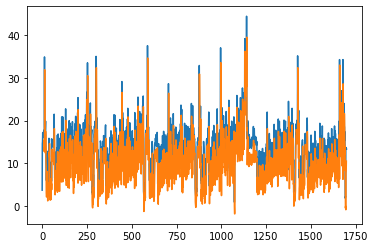

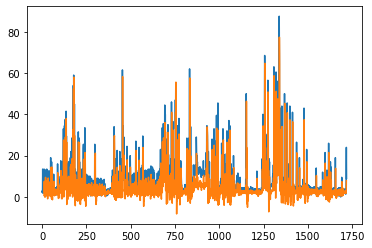

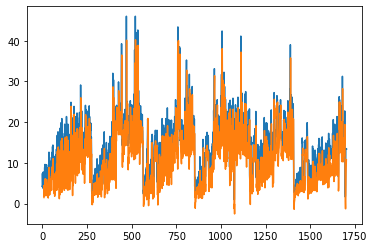

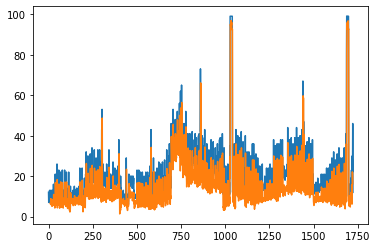

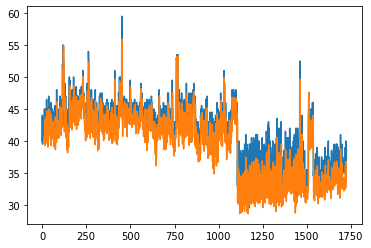

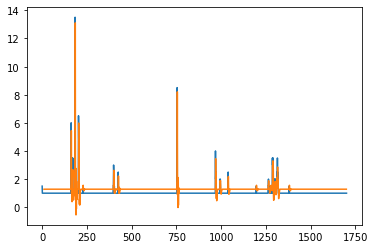

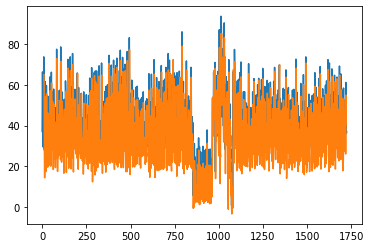

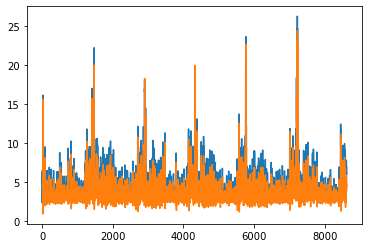

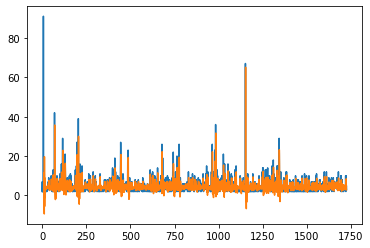

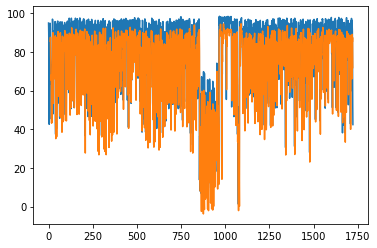

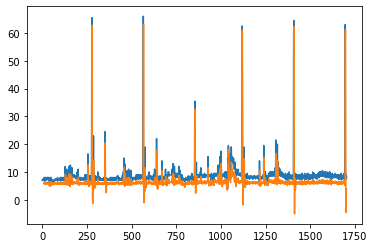

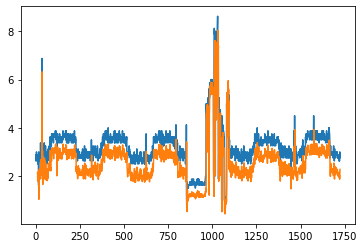

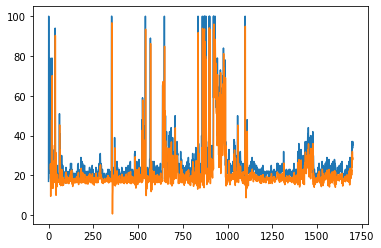

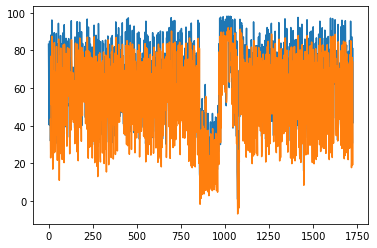

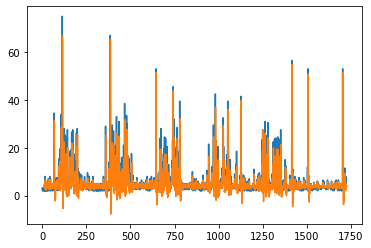

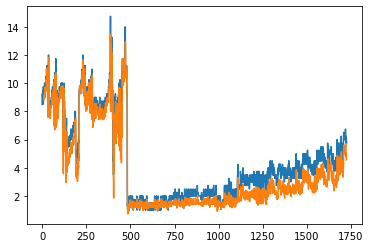

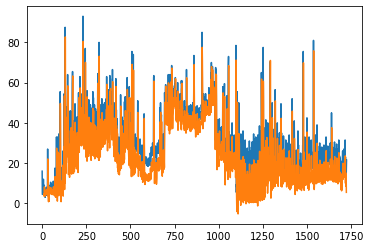

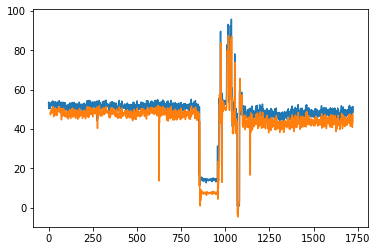

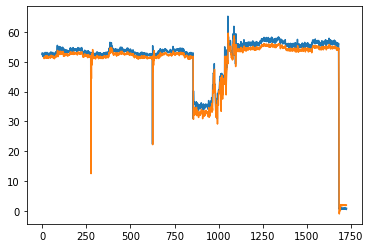

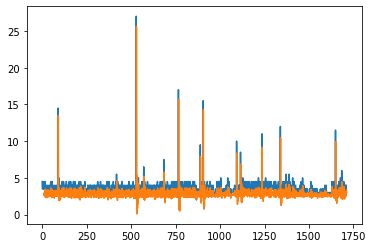

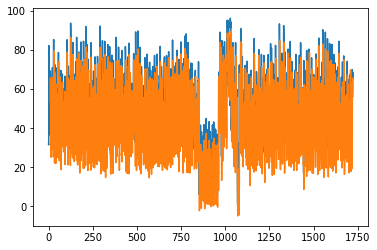

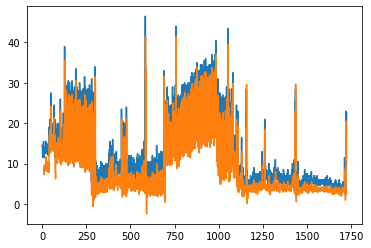

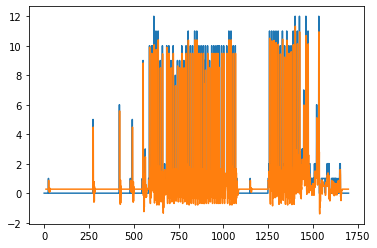

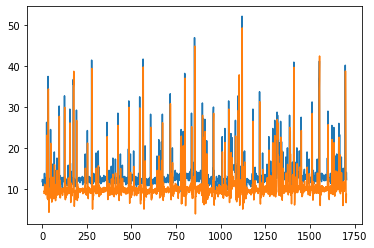

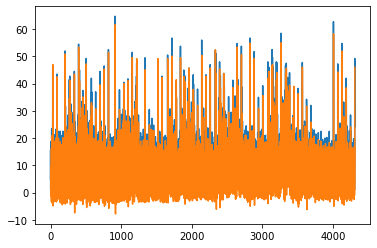

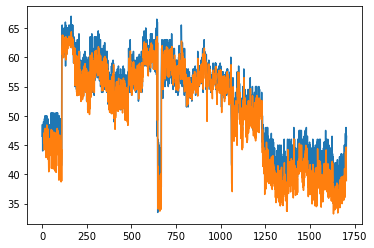

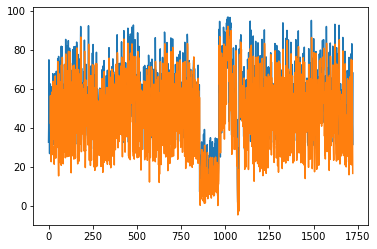

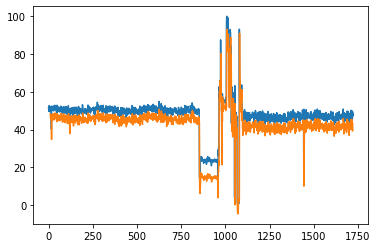

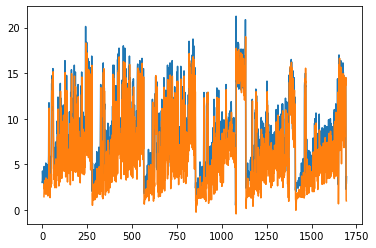

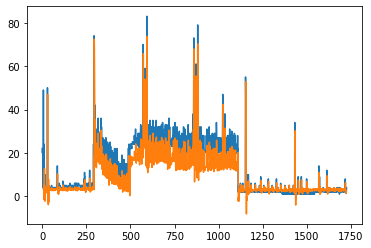

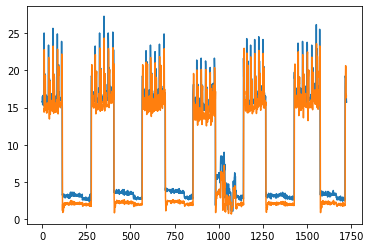

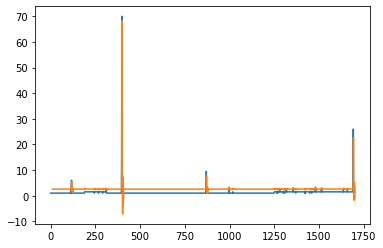

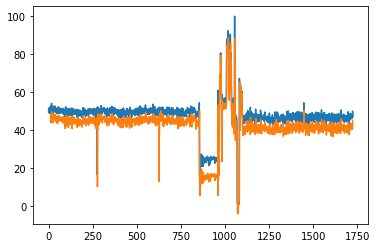

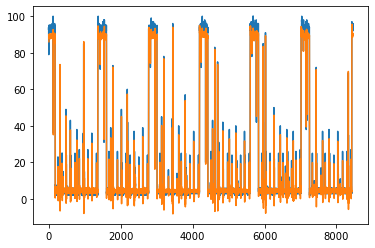

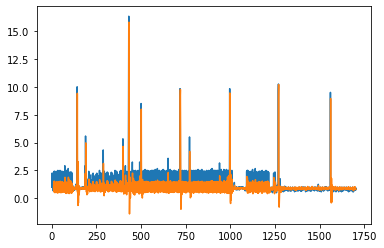

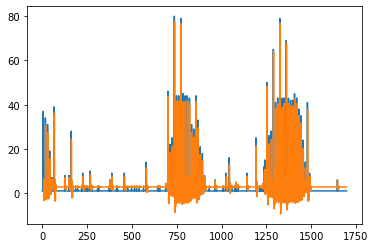

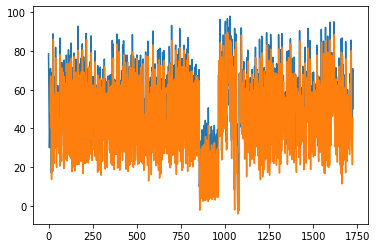

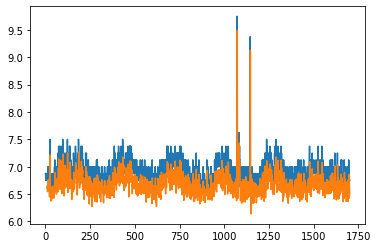

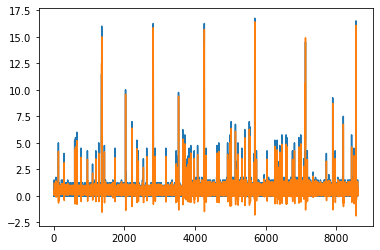

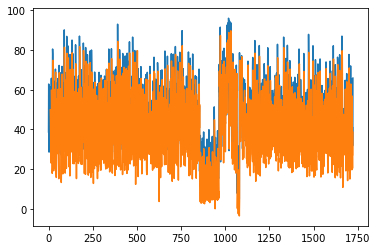

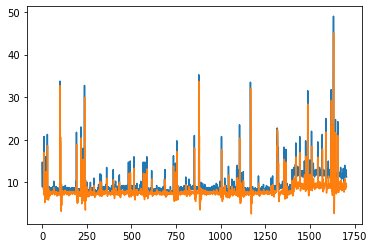

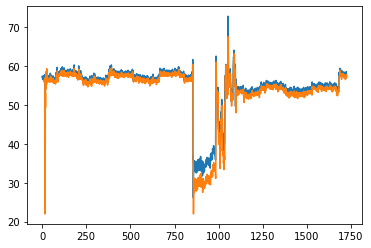

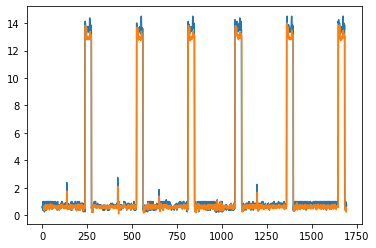

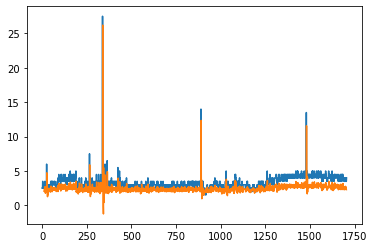

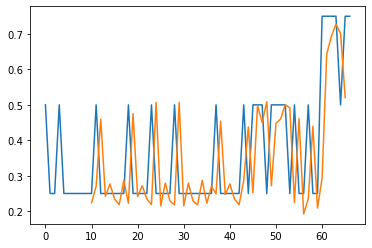

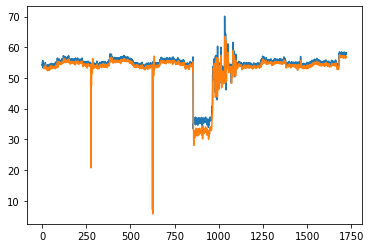

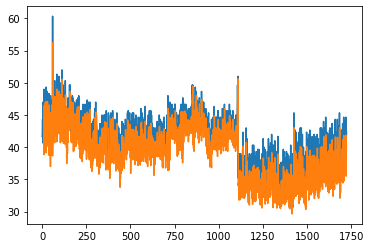

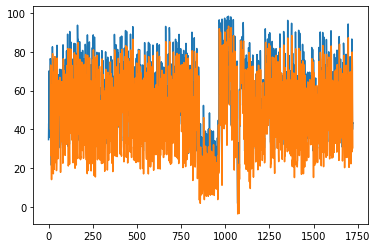

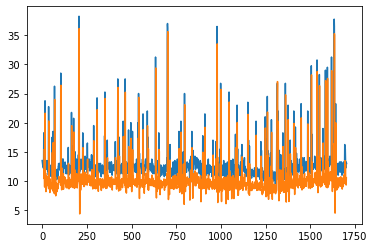

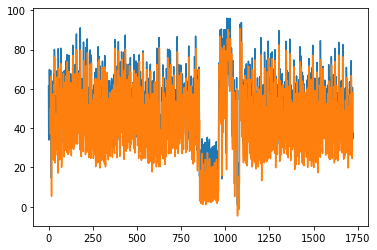

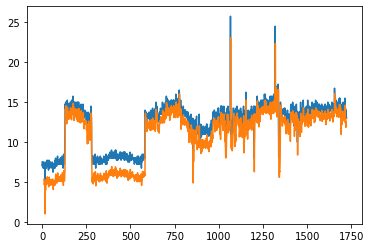

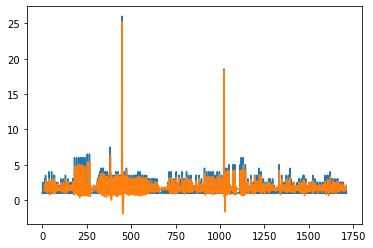

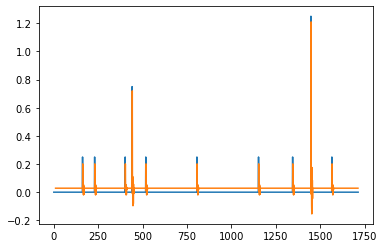

messages_unacknowledged


<ipython-input-6-b7338c78dcb8>:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


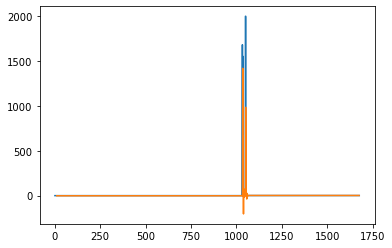

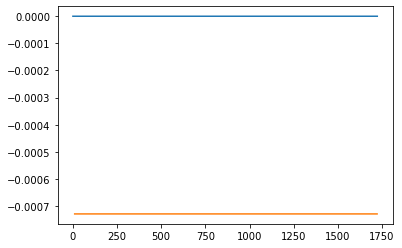

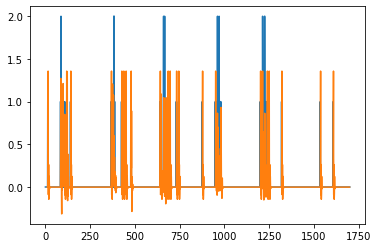

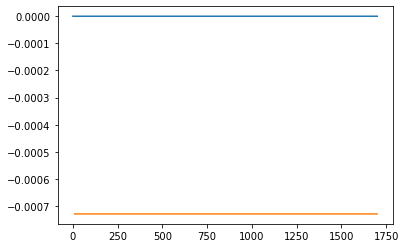

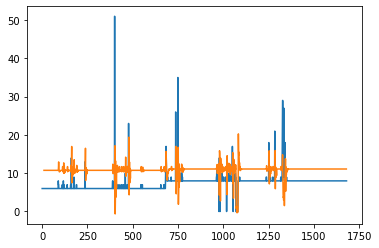

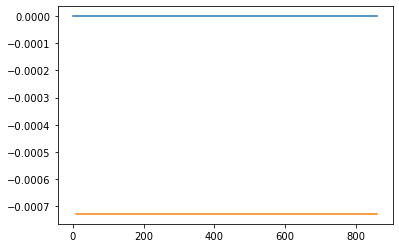

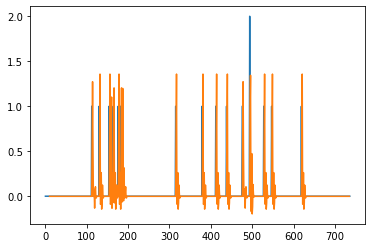

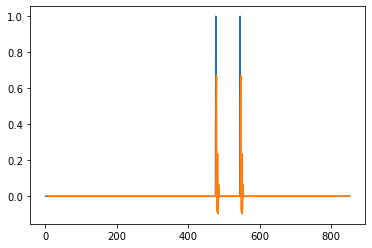

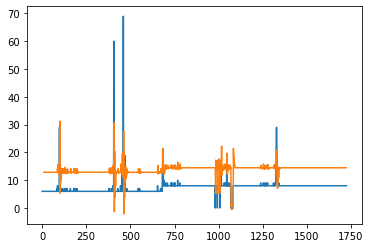

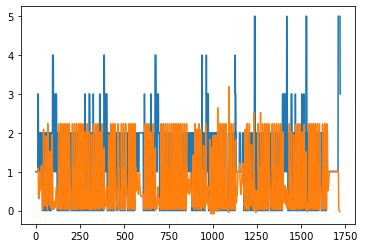

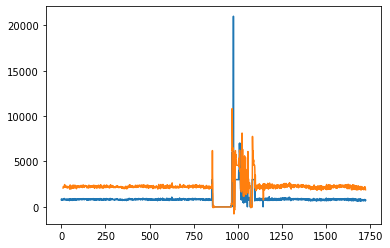

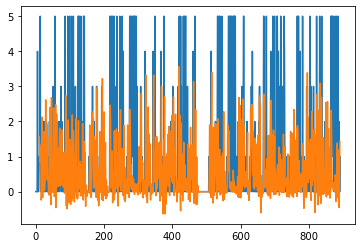

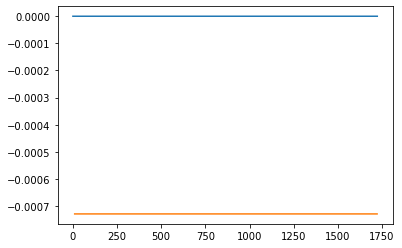

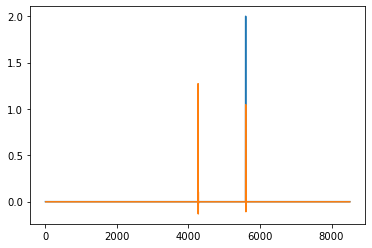

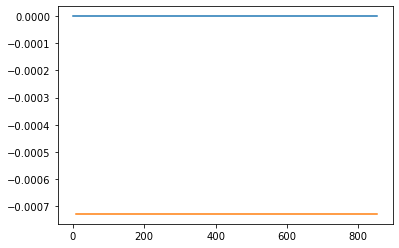

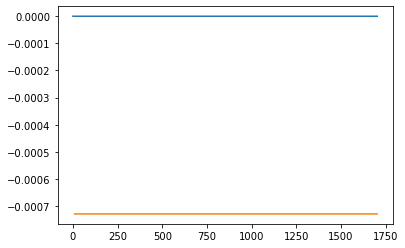

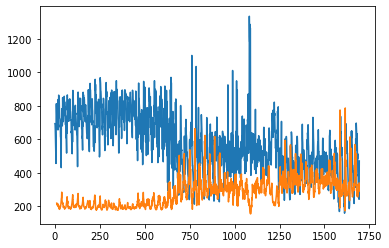

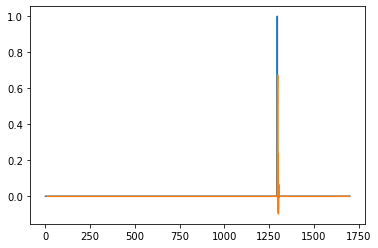

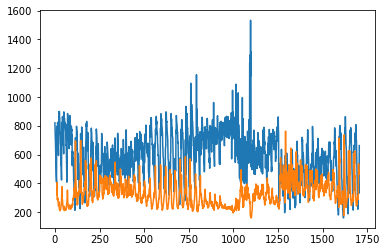

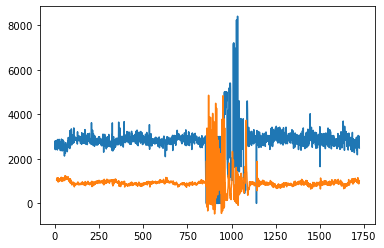

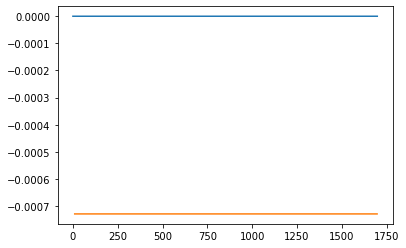

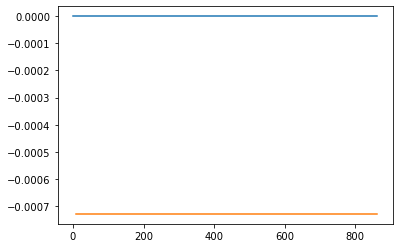

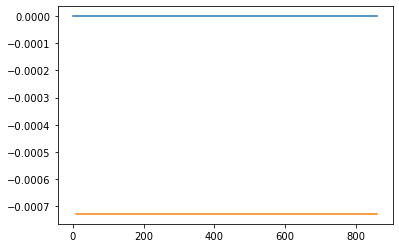

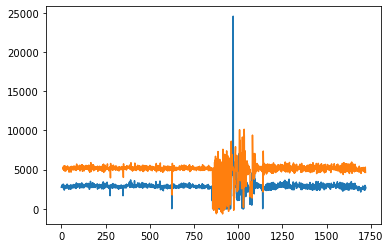

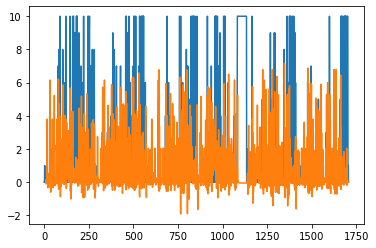

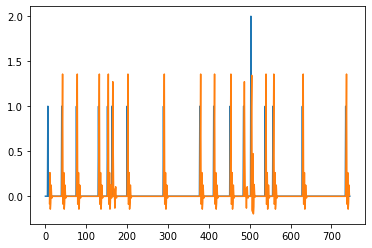

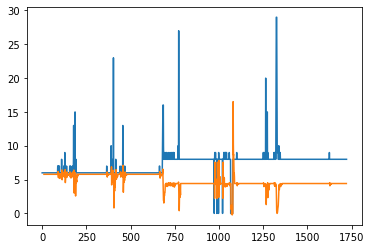

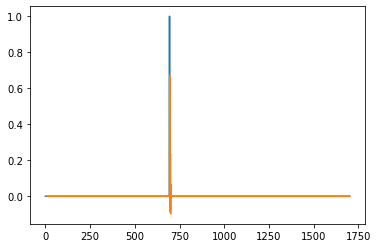

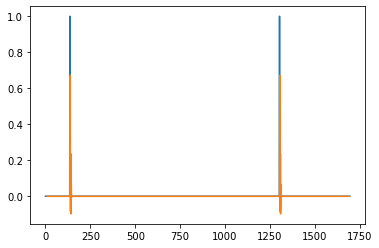

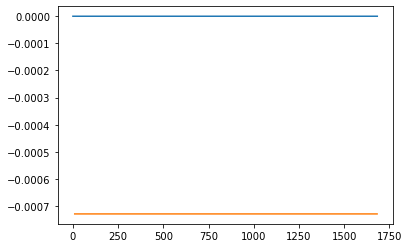

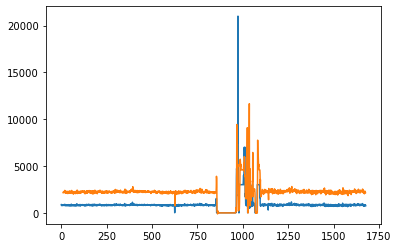

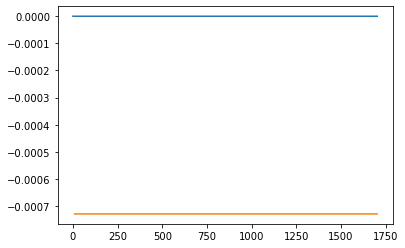

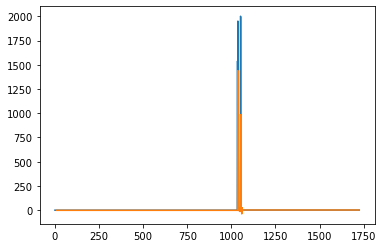

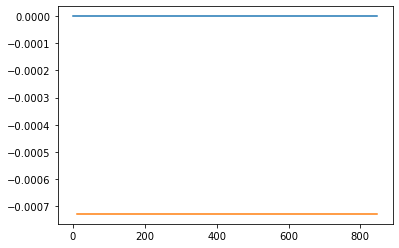

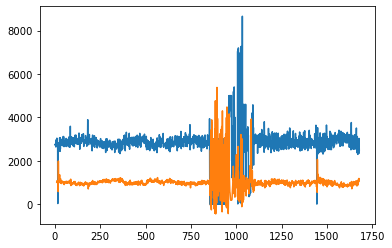

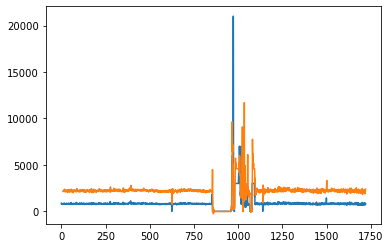

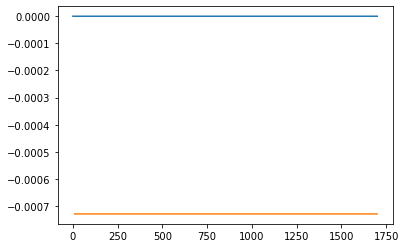

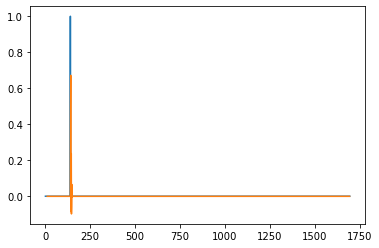

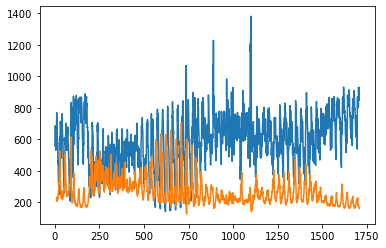

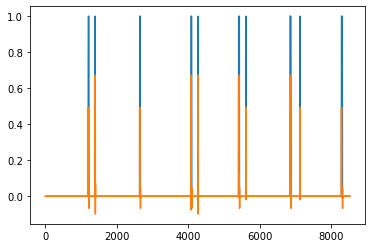

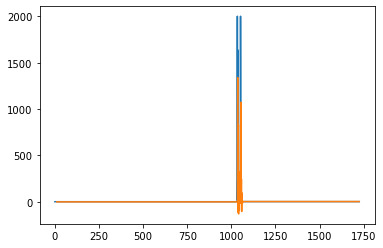

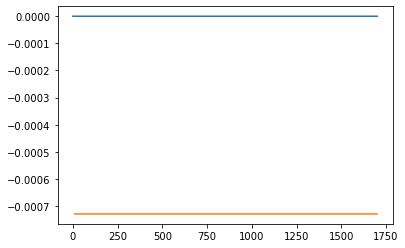

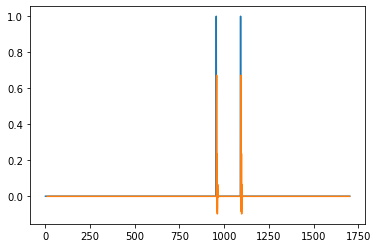

messages


<ipython-input-6-b7338c78dcb8>:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


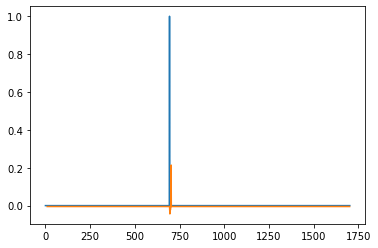

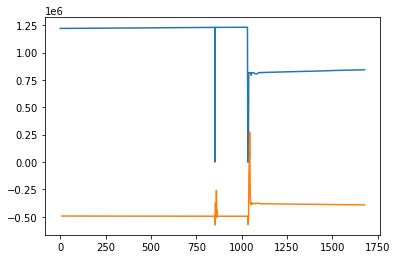

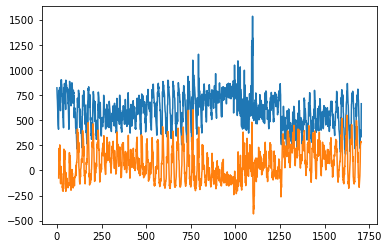

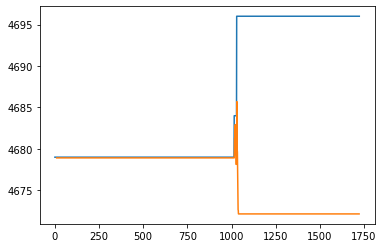

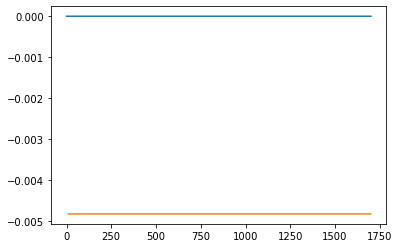

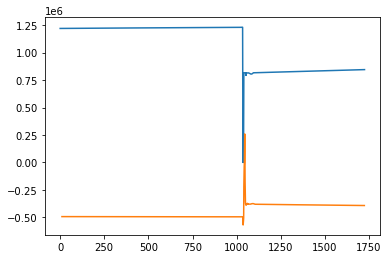

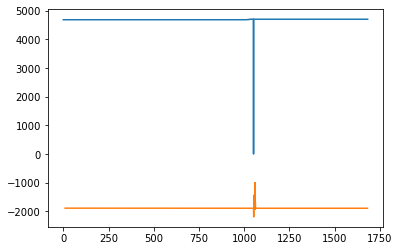

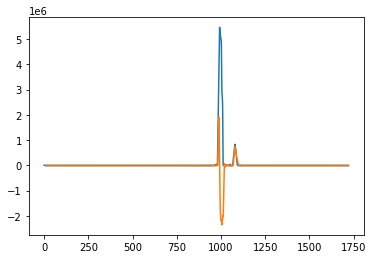

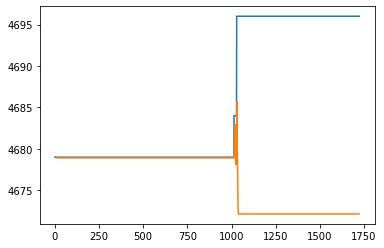

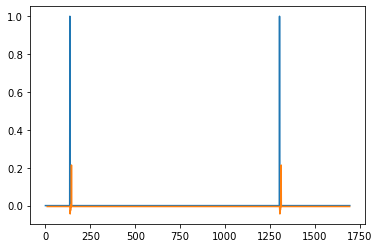

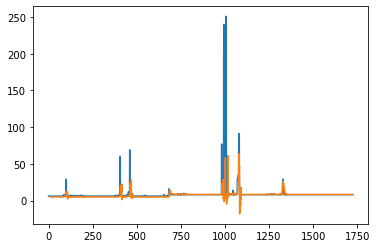

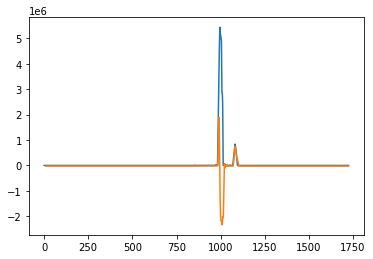

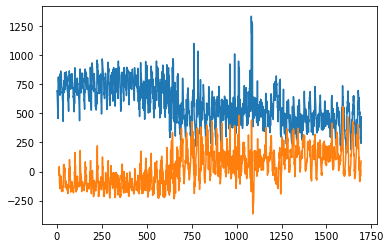

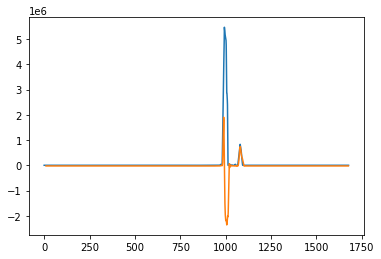

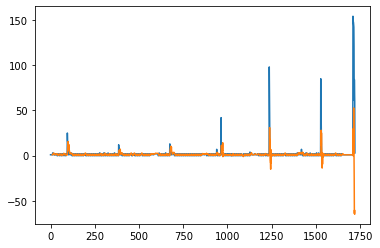

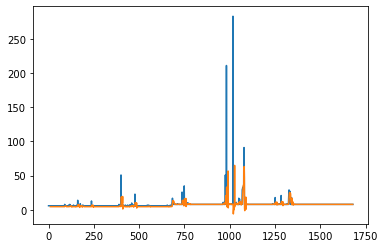

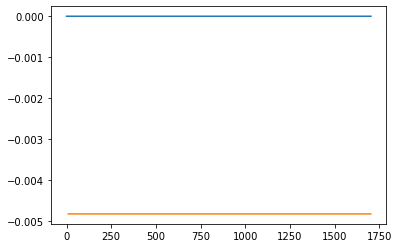

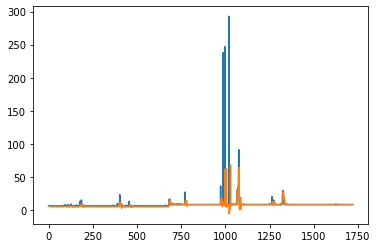

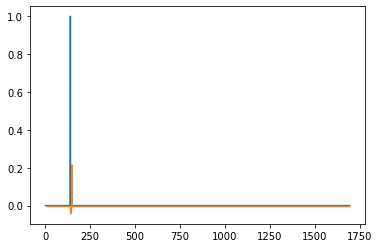

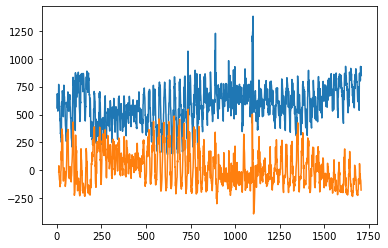

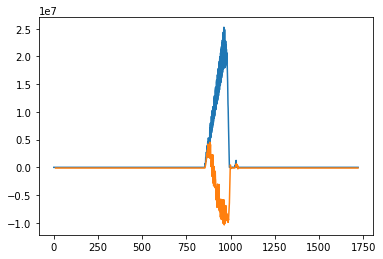

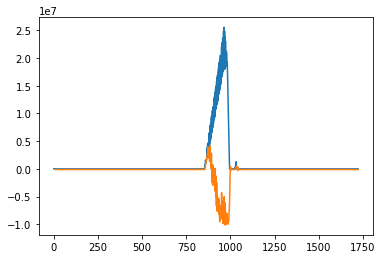

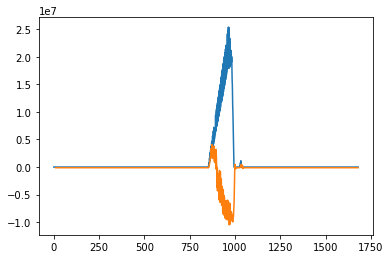

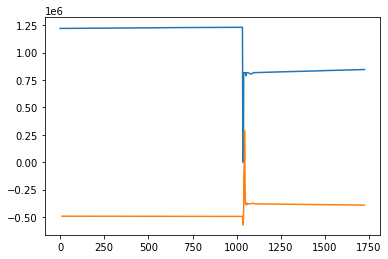

cpu_usage


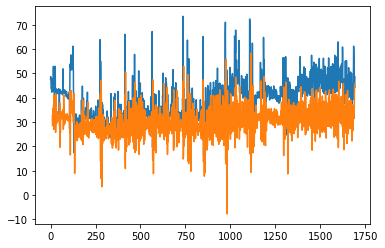

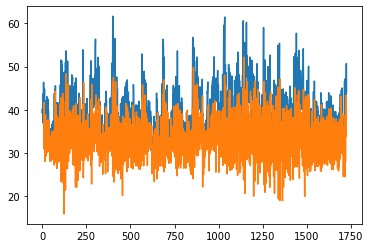

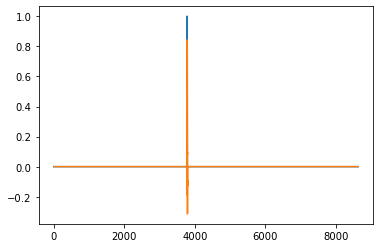

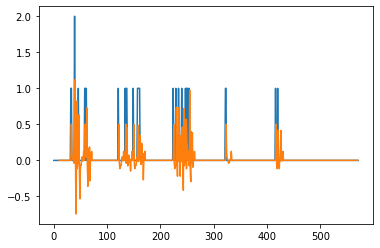

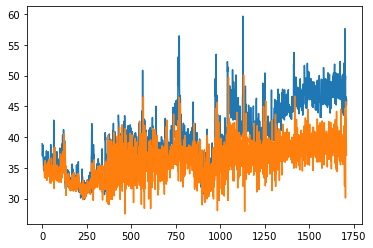

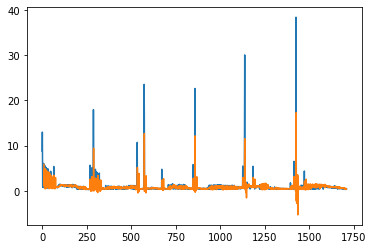

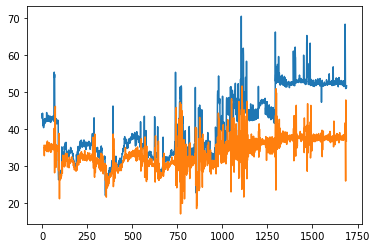

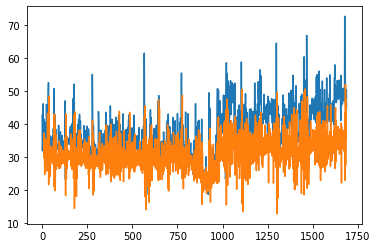

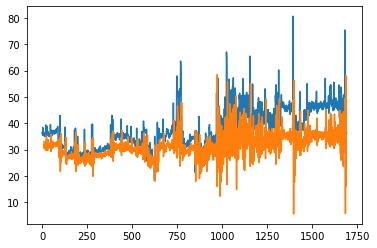

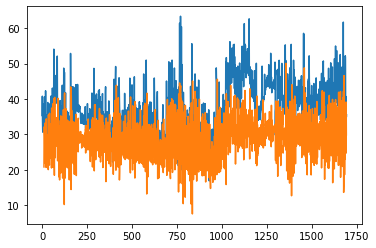

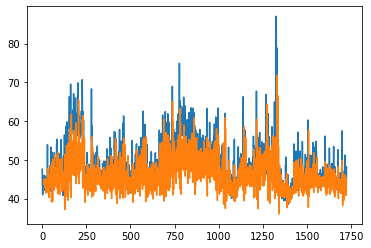

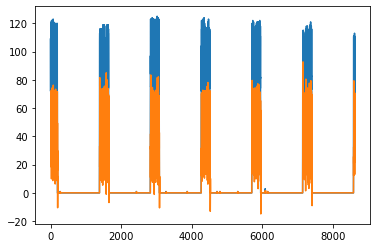

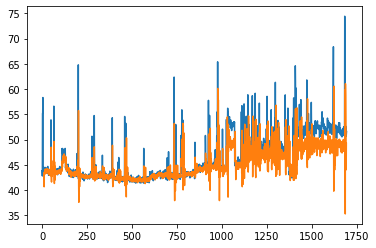

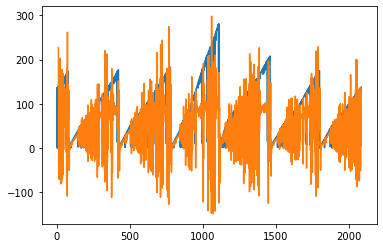

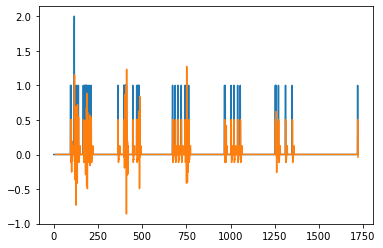

consumers


<ipython-input-6-b7338c78dcb8>:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


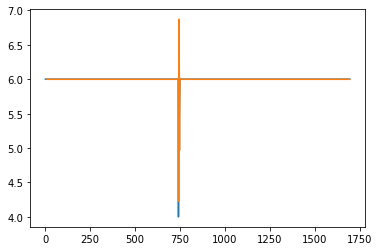

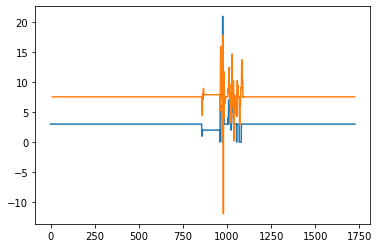

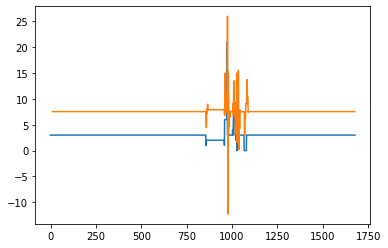

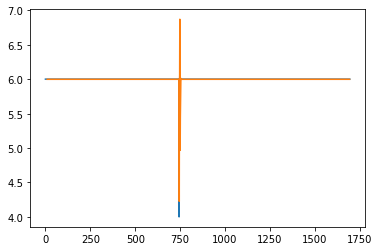

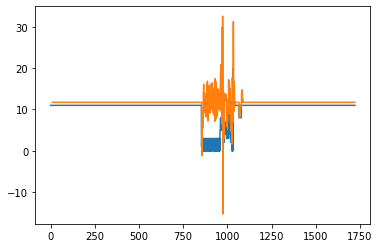

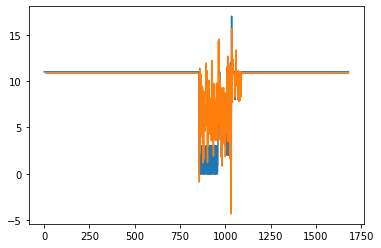

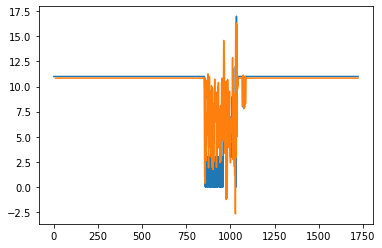

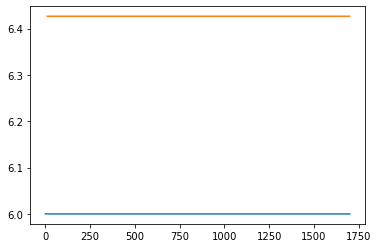

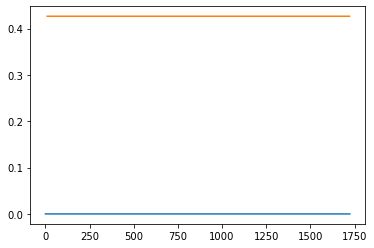

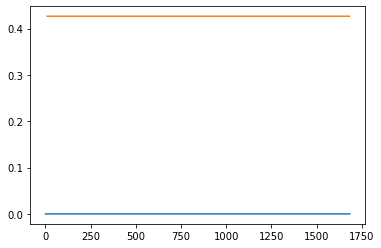

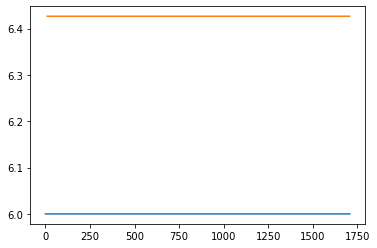

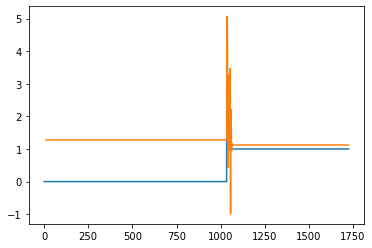

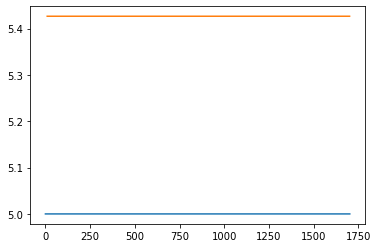

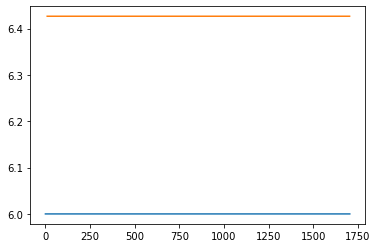

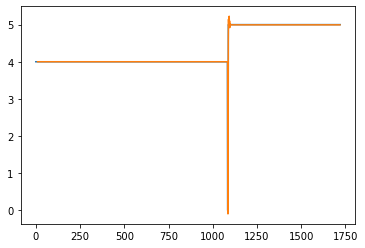

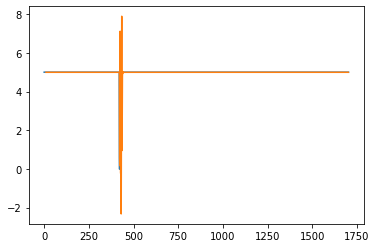

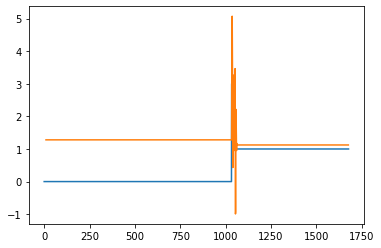

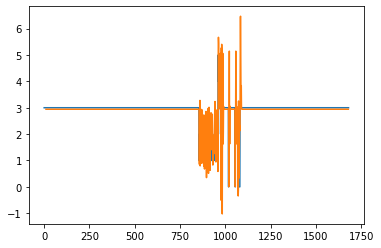

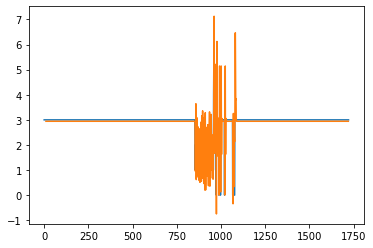

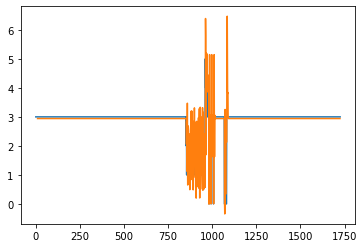

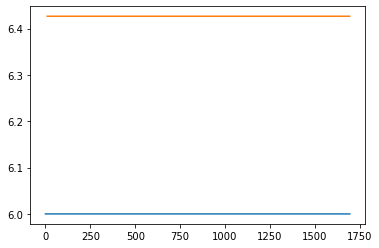

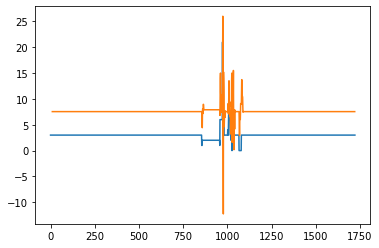

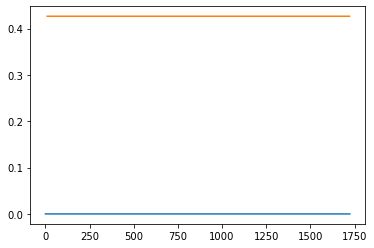

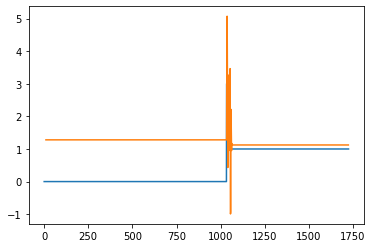

ack


<ipython-input-6-b7338c78dcb8>:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


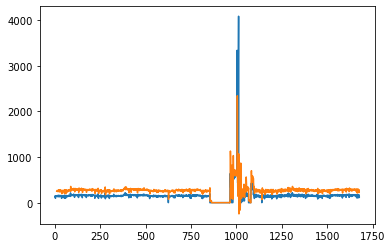

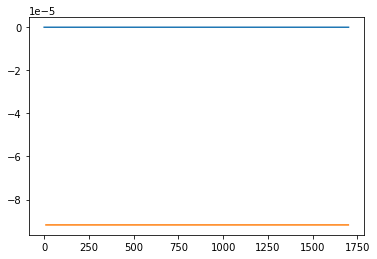

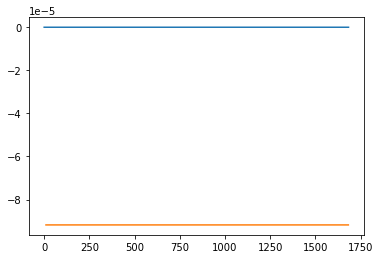

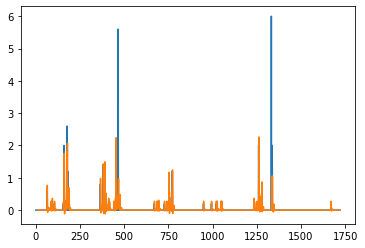

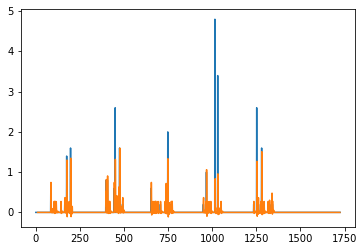

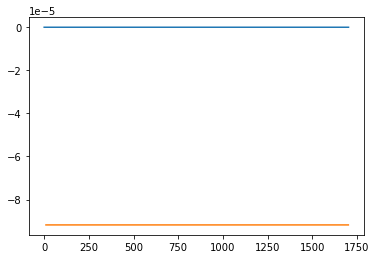

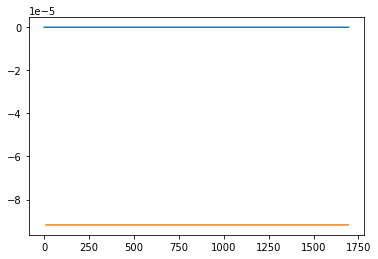

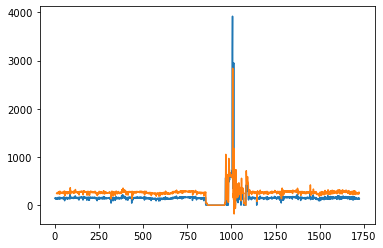

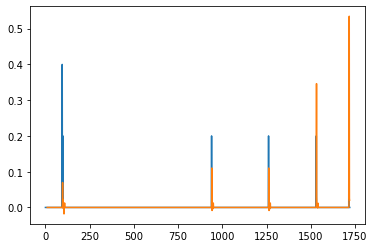

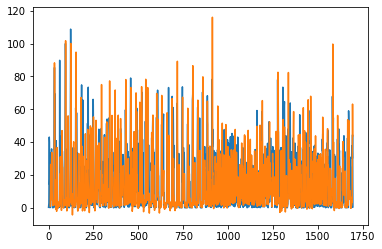

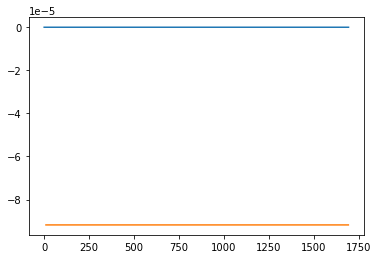

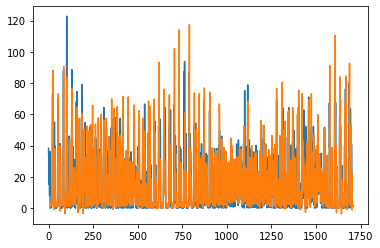

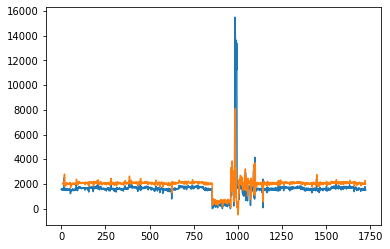

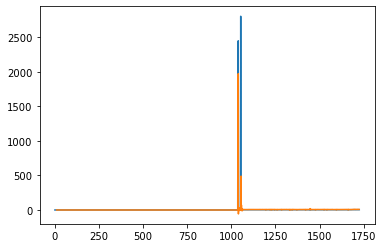

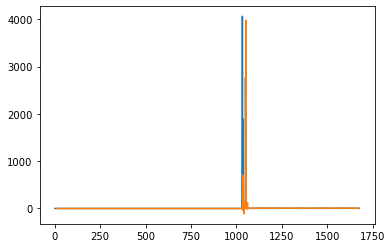

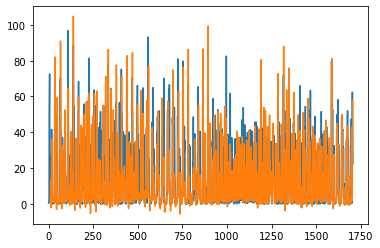

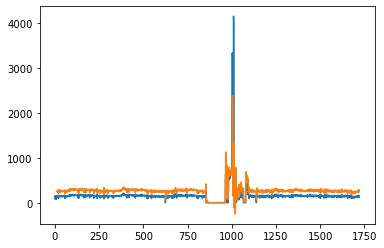

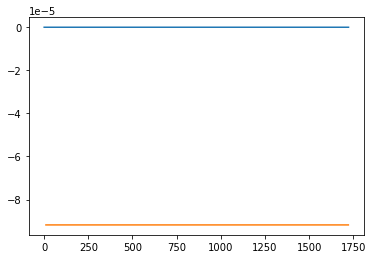

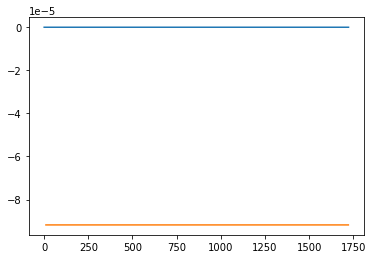

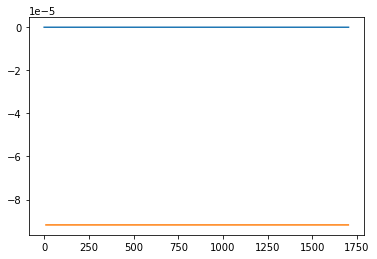

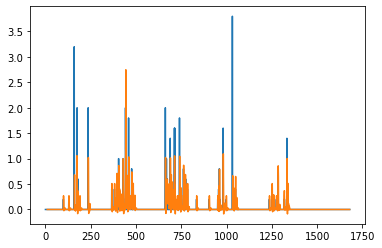

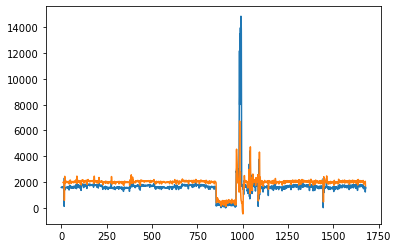

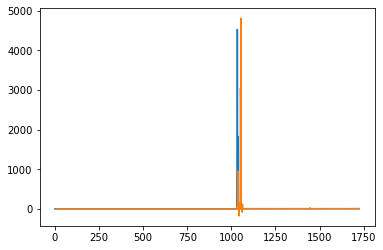

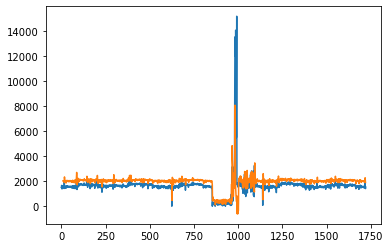

messages_ready


<ipython-input-6-b7338c78dcb8>:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


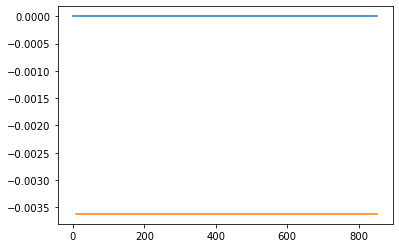

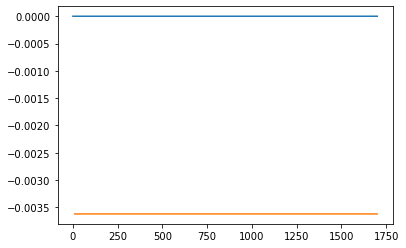

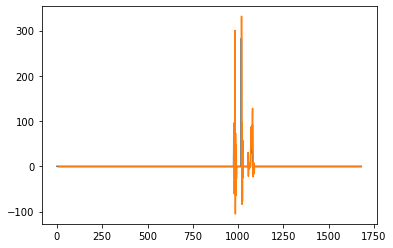

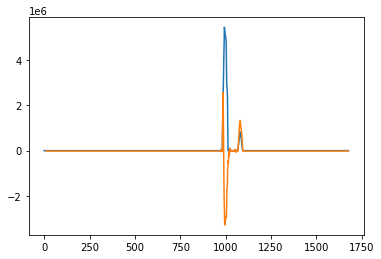

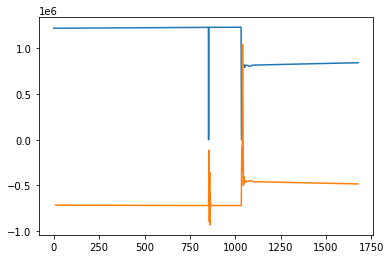

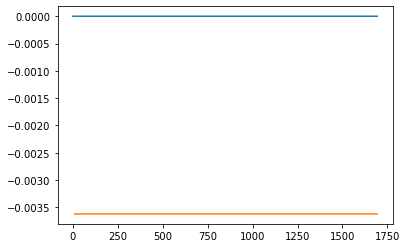

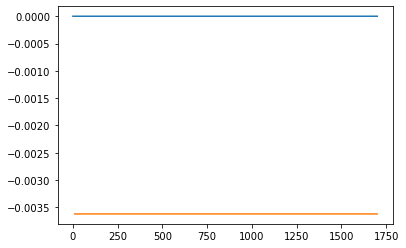

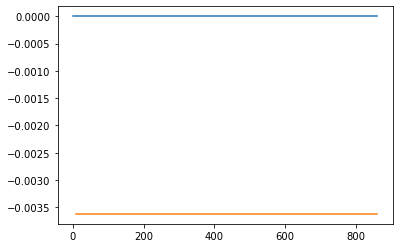

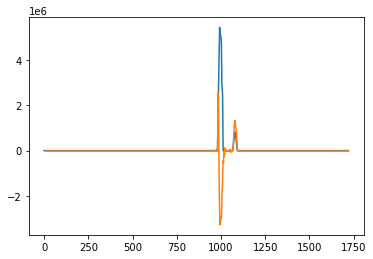

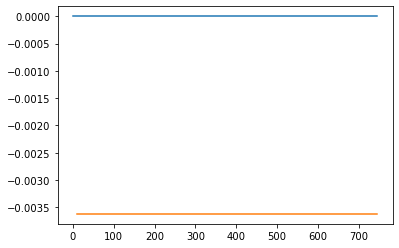

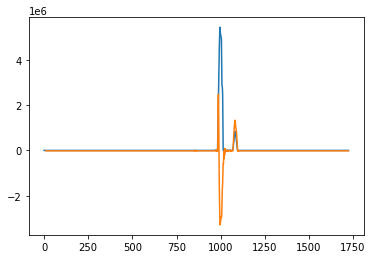

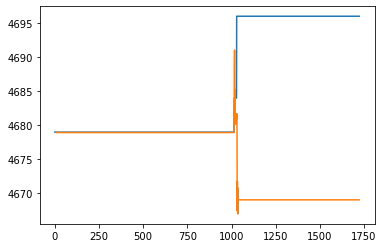

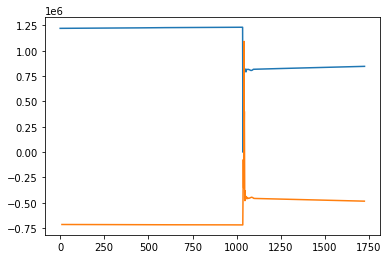

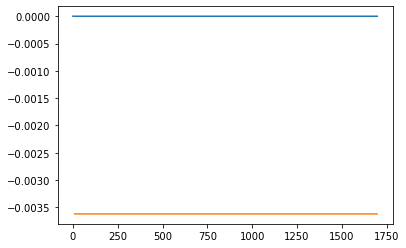

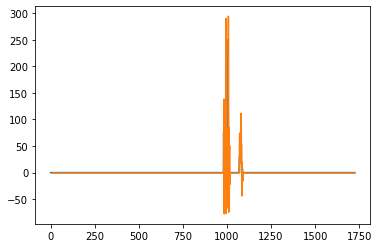

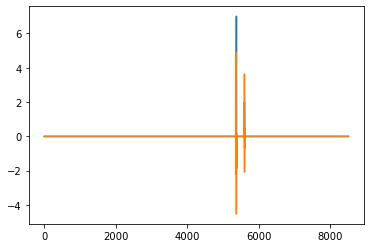

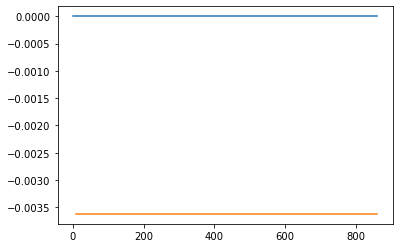

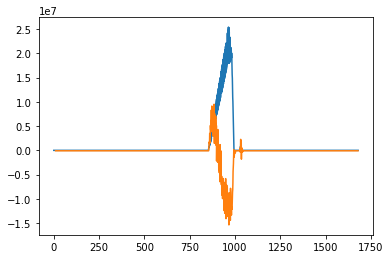

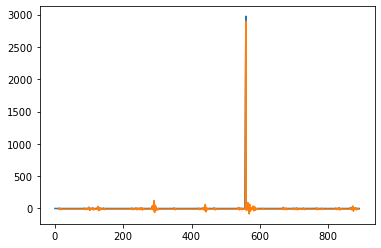

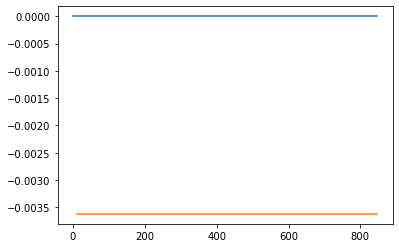

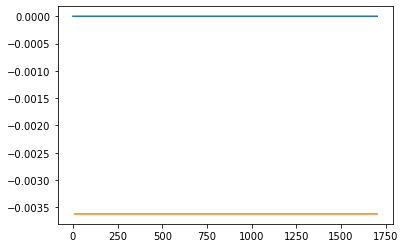

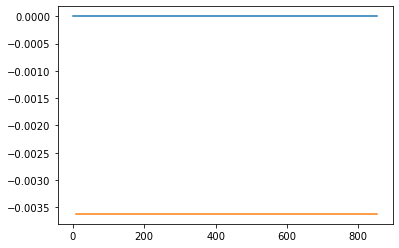

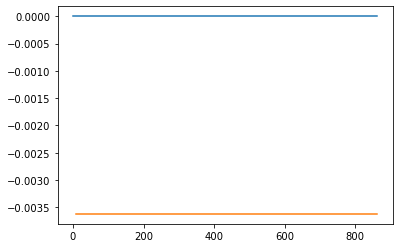

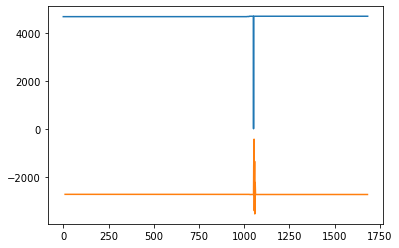

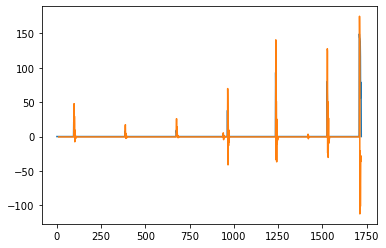

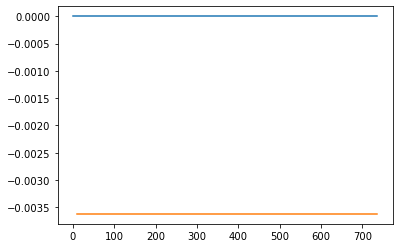

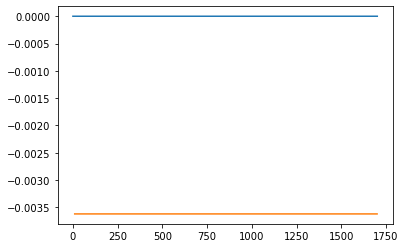

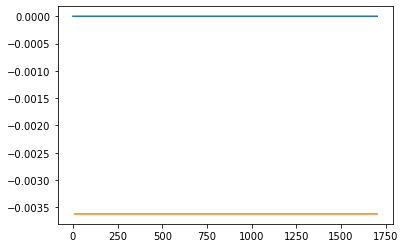

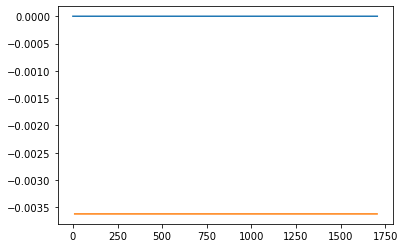

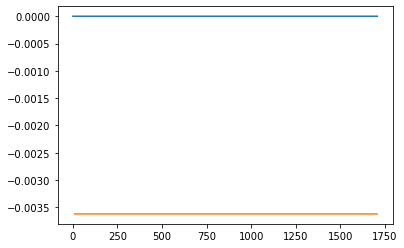

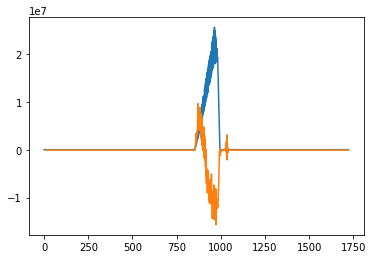

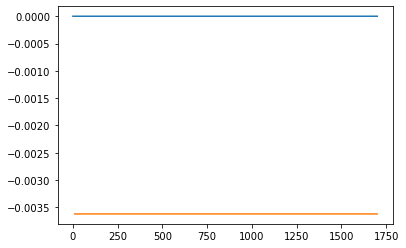

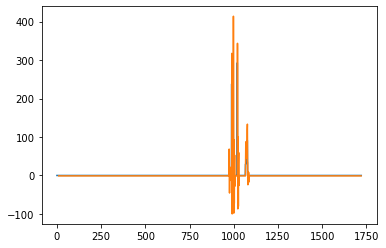

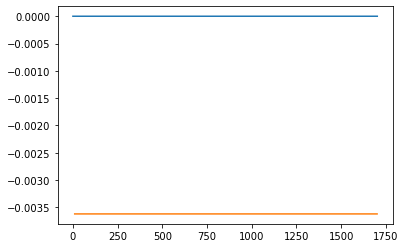

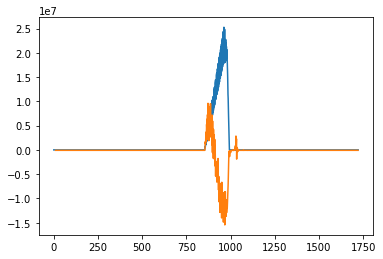

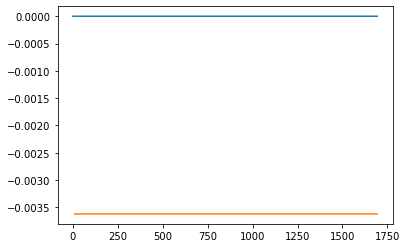

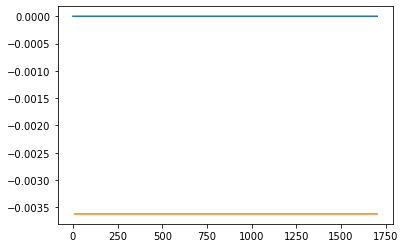

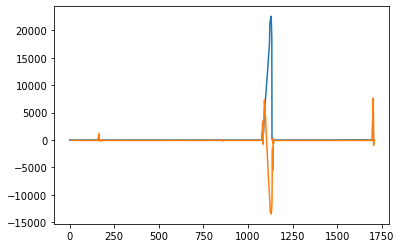

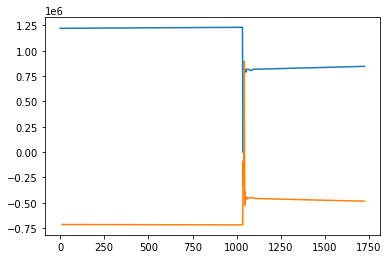

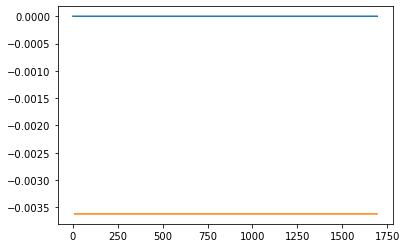

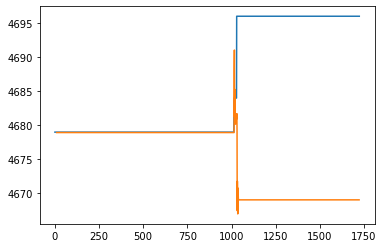

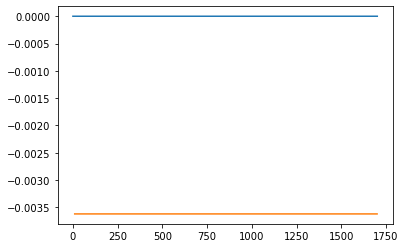

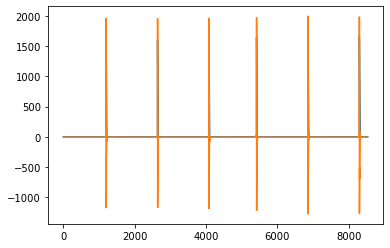

memoryConsumed


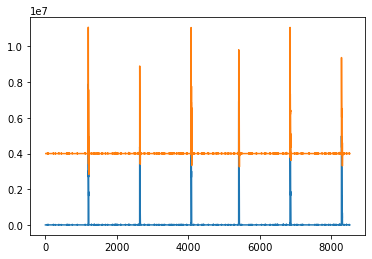

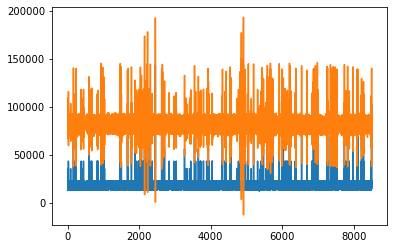

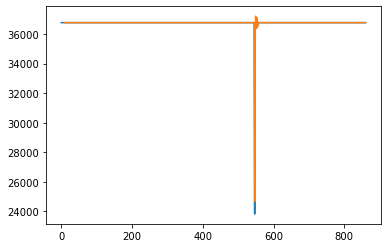

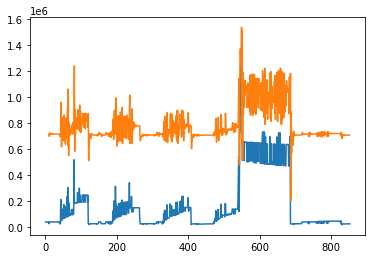

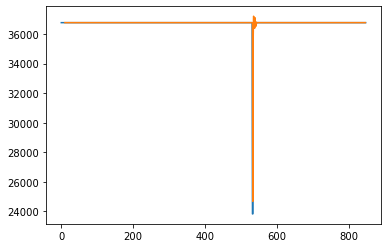

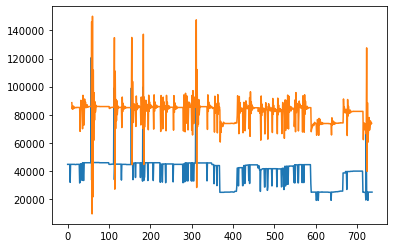

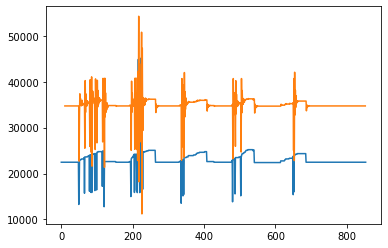

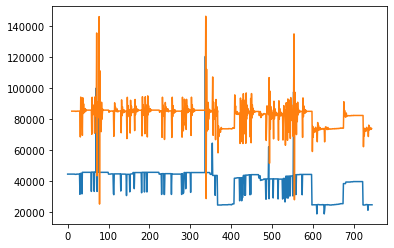

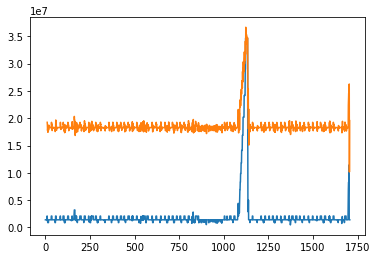

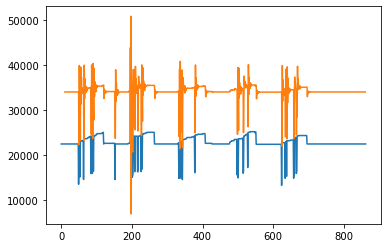

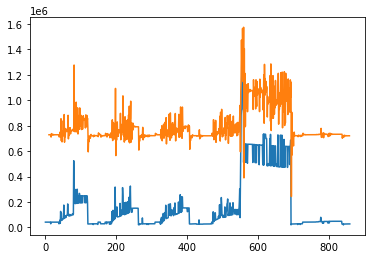

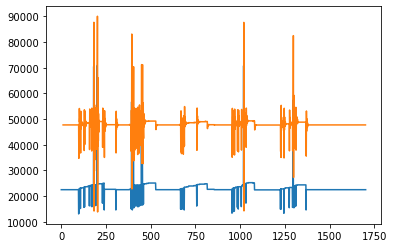

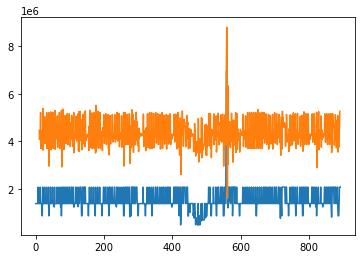

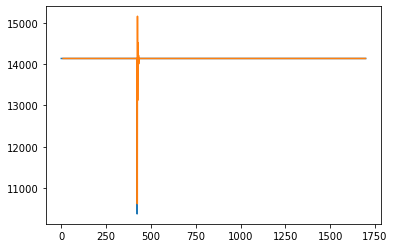

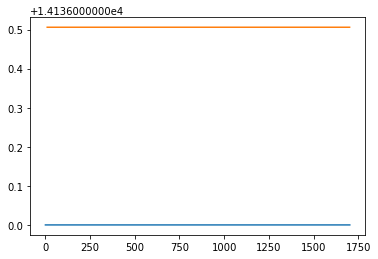

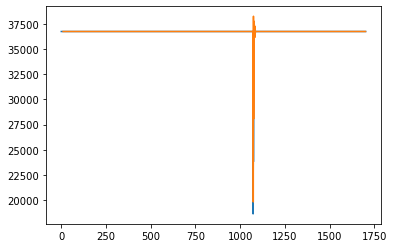

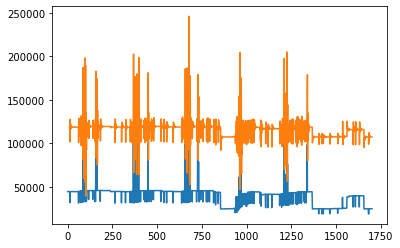

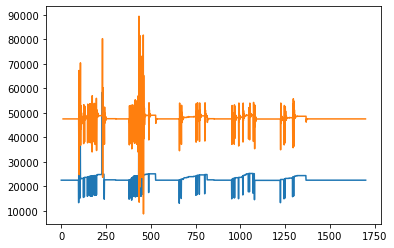

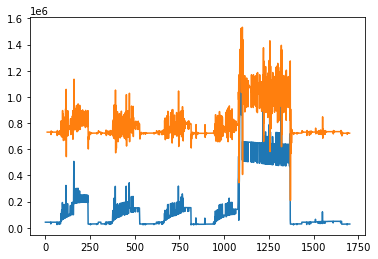

cpu


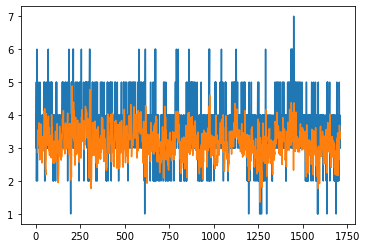

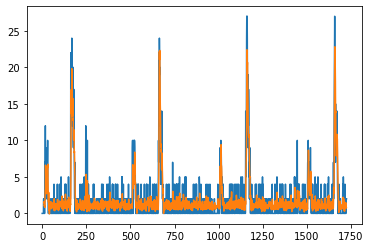

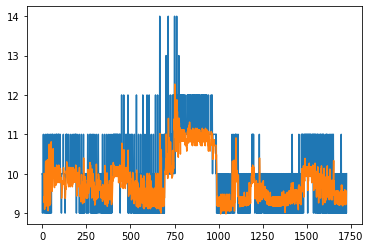

cpu_ready


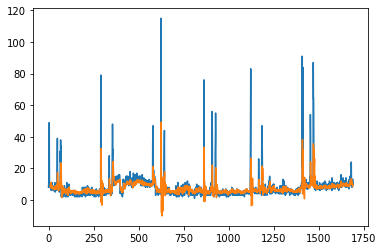

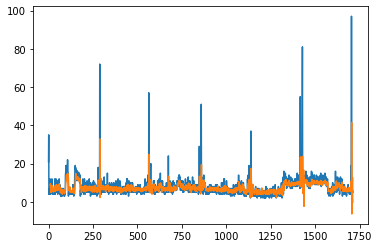

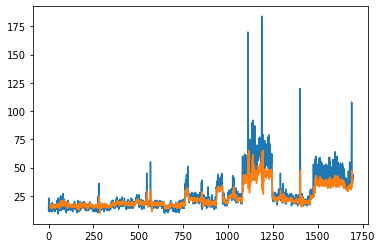

cpu_wait


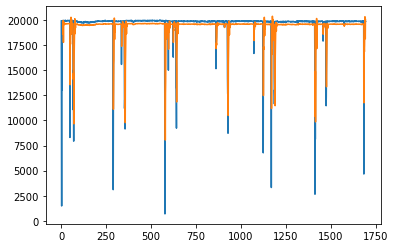

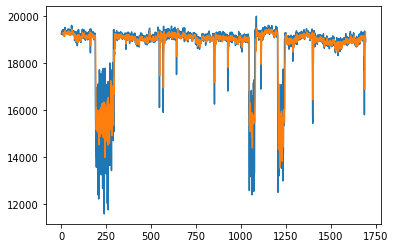

In [6]:
for indx in keys_name:
    indexOpt = dicOpt[indx]
    name = gru_data.iloc[indexOpt].loc[:,'metric_id'].values
    indexNames = ts_data[ ts_data['metric_id'] == name[0] ].index
    data = ts_data.iloc[indexNames].sort_values(by='timestamp', ascending=True).loc[:,'value']
    dataset = data.values
    dataset = dataset.astype('float32')
    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
    # reshape into X=t and Y=t+1
    look_back = 10
    x_train, y_train = create_dataset(train, look_back)
    x_valid, y_valid = create_dataset(test, look_back)
    
    # reshape input to be [samples, time steps, features]
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_valid = np.reshape(x_valid, (x_valid.shape[0], 1, x_valid.shape[1]))
    
    # create and fit the GRU network
    model = Sequential()
    model.add(GRU(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    start_train = time.time()
    model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=0)
    end_train = time.time()
    
    # make predictions
    y_pred_train = model.predict(x_train)
    start_pred = time.time()
    y_pred_valid = model.predict(x_valid)
    end_pred = time.time()
    
    # invert predictions
    y_pred_train = scaler.inverse_transform(y_pred_train)
    y_train = scaler.inverse_transform([y_train])
    y_pred_valid = scaler.inverse_transform(y_pred_valid)
    y_valid = scaler.inverse_transform([y_valid])
    # calculate root mean squared error
#     testScore = math.sqrt(mean_squared_error(y_valid[0], y_pred_valid[:,0]))
    print(indx)
    for indx_id in dic_name[indx]:
        indexNames = ts_data[ ts_data['metric_id'] == indx_id ].index
        data = ts_data.iloc[indexNames].sort_values(by='timestamp', ascending=True).loc[:,'value']
        dataset = data.values
        dataset = dataset.astype('float32')
        dataset = scaler.fit_transform(dataset.reshape(-1, 1))
        X, Y = create_dataset(dataset[:,:], look_back)
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
        start = time.time()
        prediction = model.predict(X)
        end = time.time()
        prediction = scaler.inverse_transform(prediction)
        Y = scaler.inverse_transform([Y])
        err = math.sqrt(mean_squared_error(Y[0], prediction[:,0]))
        dic_id[indx_id].append(err) 
        dic_id[indx_id].append(end_train - start_train) 
        dic_id[indx_id].append(end - start) 
        fig, ax = plt.subplots()
        # shift predictions for plotting
        trainPlot = np.empty_like(dataset)
        trainPlot[:,:] = np.nan
        trainPlot[look_back:len(dataset)-1, :] = prediction
        # plot baseline and predictions
        ax.plot(scaler.inverse_transform(dataset))
        ax.plot(trainPlot)
    plt.show()

In [7]:
pd.DataFrame(dic_id).to_csv('GRU_name2.csv', encoding='utf-8')

#### 3) Results

Beaucoup plus rapide mais beaucoup moins précis